In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
docWord = np.load("science2k-doc-word.npy")


### k-means
1. Select k points as means
2. Assign each point to its closest center
3. Compute clusters centers
4. Repeat 2-4

In [155]:
# def assignPointsToClusters(points, clustersCenters, k):
#     assignment = np.empty(points.shape[0])
#     withinDist = 0
#     for i in range(points.shape[0]):
#         minDist = np.infty
#         for cluster in range(k):
#             dist = np.linalg.norm(points[i] - clustersCenters[cluster])
#             if dist < minDist:
#                 minDist = dist
#                 bestCluster = cluster
#         assignment[i] = bestCluster
#         withinDist += minDist
#     return assignment, withinDist
#
# def computeClustersCenters(points, assignment, k):
#     clustersCenters = np.empty((k,points.shape[1]))
#     for cluster in range(k):
#         center = np.mean(points[assignment == cluster], axis=0)
#         clustersCenters[cluster] = center
#     return clustersCenters
#
# def kMeans(points, k, n_iter):
#     withinDists = np.empty(n_iter)
#     for i in range(n_iter):
#         clustersCenters = points[np.random.randint(0,points.shape[0],k)]
#         withinDist = 0
#         oldWithinDist = -1
#         while withinDist != oldWithinDist:
#             oldWithinDist = withinDist
#             assignment, withinDist = assignPointsToClusters(points, clustersCenters, k)
#             clustersCenters = computeClustersCenters(points, assignment, k)
#             print('W'+str(i)+' = ' + str(round(withinDist,5)), end='\r')
#         withinDists[i] = withinDist
#     minWithinDist = np.min(withinDists)
#     stdWithinDist = np.std(withinDists)
#     return minWithinDist, stdWithinDist
#
# for k in range(2,21):
#     print('k = '+str(k))
#     minWithinDist, std = kMeans(docWord, k, n_iter=6)
#     print('W = '+str(minWithinDist))
#     print('CI=['+str(minWithinDist-std)+' - '+str(minWithinDist+std)+']')


In [156]:
# kMeans(docWord, 10, n_iter=6)

In [157]:
kMeans_algo = KMeans()
k_grid = {'n_clusters': np.arange(2,21)}
k_grid_cv = GridSearchCV(kMeans_algo, k_grid, cv=5, n_jobs=-1)
k_grid_cv.fit(docWord, y=None)

GridSearchCV(cv=5, estimator=KMeans(), n_jobs=-1,
             param_grid={'n_clusters': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20])})

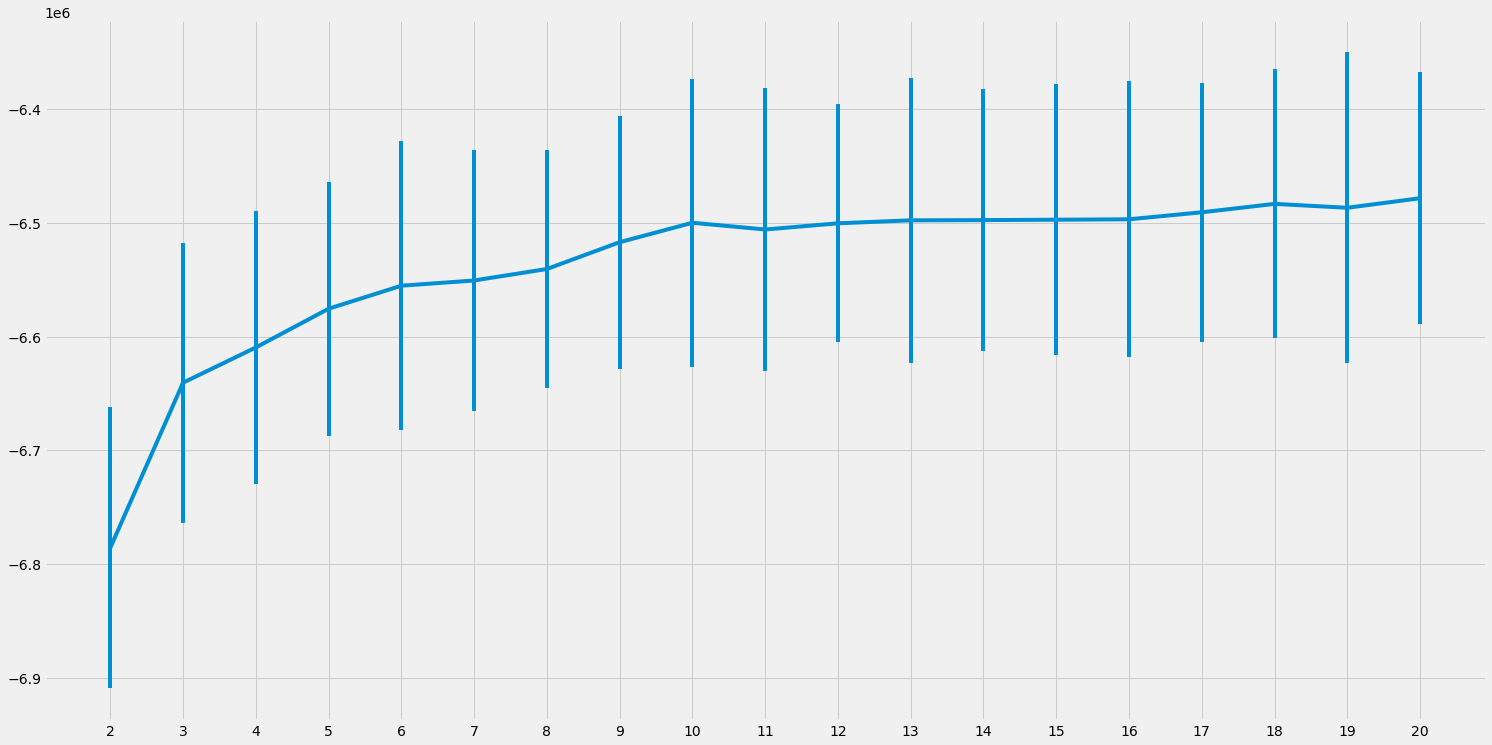

In [158]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=[23,12])
k_grid_results = pd.DataFrame(k_grid_cv.cv_results_)
plt.errorbar(np.arange(2,21), k_grid_results['mean_test_score'], yerr=k_grid_results['std_test_score'])
plt.grid(True)
# plt.yticks(np.arange(-6.9e6, -6.3e6, 0.05e6))
plt.xticks(np.arange(2,21));

In [2]:
kmax = 20
sil = []
iner = []
for k in range(2, kmax+1):
  kmeansmodel = KMeans(n_clusters = k).fit(docWord)
  labels = kmeansmodel.labels_
  inertia = kmeansmodel.inertia_
  sil.append(silhouette_score(docWord, labels, metric = 'euclidean'))
  iner.append(kmeansmodel.inertia_)

KeyboardInterrupt: 

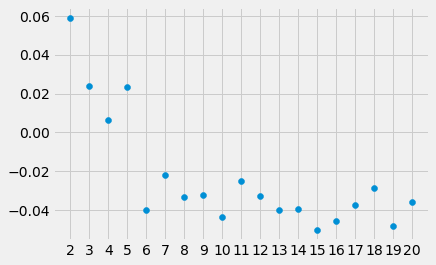

In [160]:
plt.scatter(np.arange(2,21), sil)
plt.grid(True)
plt.xticks(np.arange(2,21));

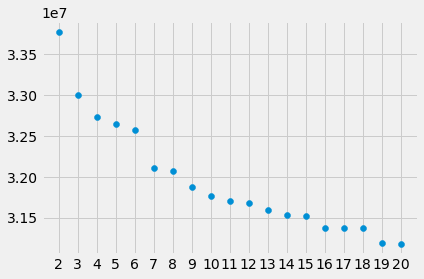

In [161]:
plt.scatter(np.arange(2,21), iner)
plt.grid(True)
plt.xticks(np.arange(2,21));

It's not immediately clear which k value is optimal due to the lack of elbows in the inertia plot or silhouette peaks. However, a k value of 7 appears to form a slight elbow, a local silhouette peak, and somewhat comparable results to cross validation (which returned an optimal k of 5). We shall proceed with this value.

In [3]:
x_mean = pd.DataFrame(docWord).describe().loc['mean']
print(x_mean)

0       6.121581
1       3.394095
2       9.015467
3       7.278490
4       8.952740
          ...   
5471   -0.534182
5472   -0.604428
5473   -0.504000
5474   -0.582830
5475   -0.569696
Name: mean, Length: 5476, dtype: float64


In [6]:
n_clusters = 7
selected_kmeans = KMeans(n_clusters=n_clusters).fit(docWord)
labels = selected_kmeans.labels_
cluster_centers = selected_kmeans.cluster_centers_
subtracted = cluster_centers - x_mean.to_numpy()

In [7]:
farthest = np.zeros([n_clusters,10])
word_list = open('science2k-vocab.txt','r').read().split()

for index, row in pd.DataFrame(subtracted).iterrows():
    descending_sorted = np.argsort(-row)
    farthest[index,:] = descending_sorted[0:10]

farthest_words = np.empty([n_clusters,10], dtype='<U20')

for cluster in range(n_clusters):
    farthest_words[cluster,:] = [word_list[i] for i in farthest[cluster,:].astype('int').tolist()]

pd.DataFrame(farthest_words)

,0,1,2,3,4,5,6,7,8,9
0,assay,binding,residues,membrane,min,sds,incubated,lysates,tagged,proteins
1,says,researchers,scientists,year,people,just,get,last,years,say
2,energy,fig,shows,electron,density,measured,order,solid,constant,structure
3,cells,expression,cell,protein,fig,wild,expressed,control,induced,gene
4,values,global,north,estimates,lower,years,estimate,period,ocean,south
5,sequence,protein,conserved,amino,acid,proteins,domain,binding,sequences,site
6,mail,compass,author,issue,page,sciences,article,news,policy,readers


In [8]:
from scipy.spatial import distance
title_list = open('science2k-titles.txt','r').read().split('\n')
title_list.append('Cluster size limited')

n_documents = len(selected_kmeans.labels_)
distances_to_center = np.zeros([n_documents,2])

for document in range(n_documents):
    cluster = selected_kmeans.labels_[document]
    cluster_center = cluster_centers[cluster]
    distances_to_center[document,0] = cluster
    distances_to_center[document,1] = distance.euclidean(cluster_center, docWord[document])

distances_to_center = pd.DataFrame(distances_to_center)

closest_documents = np.empty([n_clusters,10])
closest_documents[:] = np.NaN

for cluster in range(n_clusters):
    distances_per_cluster = distances_to_center.loc[distances_to_center[0] == cluster][1]
    closest = np.argsort(distances_per_cluster)[0:10].to_numpy()
    if len(closest) < 10:
        append = np.zeros([10 - len(closest),1])
        append[:] = len(title_list) - 1
        closest = np.append(closest, append)
    closest_documents[cluster,:] = closest

In [9]:
closest_titles = np.empty([n_clusters,10], dtype='<U100')

for cluster in range(n_clusters):
    closest_titles[cluster,:] = [title_list[i] for i in closest_documents[cluster,:].astype('int').tolist()]

pd.DataFrame(closest_titles)

,0,1,2,3,4,5,6,7,8,9
0,"""Archaeology in the Holy Land""","""Corrections and Clarifications: Commercializa...","""Corrections and Clarifications: First-Princip...","""Brane-Worlds""","""Resistance to Bt Toxins""","""Will Tribal Knowledge Survive the Millennium?""","""Duchamp's L.H.O.O.Q.-From 1919 or 1930?""","""Baedeker's Guide, or Just Plain 'Trouble'?""",Cluster size limited,Cluster size limited
1,"""Direct Observation of Dynamical Heterogeneiti...","""Dynamics of the Pacific-North American Plate ...","""New Probe to Chart the Milky Way""","""Redox Signaling in Chloroplasts: Cleavage of ...","""Timeline Travails""","""Corrections and Clarifications: Crystal Struc...","""Coupling of Stress in the ER to Activation of...","""Neutral, Single-Component Nickel (II) Polyole...","""Honeybee Navigation: Nature and Calibration o...","""Regulation of Protein Secretion through Contr..."
2,"""Multidecadal Changes in the Vertical Temperat...","""Polarization of Chemoattractant Receptor Sign...","""Voltage- and Tension-Dependent Lipid Mobility...","""Honeybee Navigation: Nature and Calibration o...","""Population Dynamical Consequences of Climate ...","""A Tale of Two Futures: HIV and Antiretroviral...","""Why Stem Cells?""","""Corrections and Clarifications: Crystal Struc...","""Evidence for a High Frequency of Simultaneous...","""Formation of Cyclic Water Hexamer in Liquid H..."
3,"""A Powerhouse Divided""","""Clarification of AstraZeneca's R&D Strategies""","""HIV Infection and Dementia""","""The Latest News from Mars""","""Mirrorless Lasing from Mesostructured Wavegui...","""Connectivity of Marine Populations: Open or C...","""Regulation of Protein Secretion through Contr...","""Interpreting Differential Temperature Trends ...","""Equilibrium Regained: From Nonequilibrium Cha...","""The Spirit of Discovery"""
4,"""Charon's First Detailed Spectra Hold Many Sur...","""Honeybee Navigation: Nature and Calibration o...","""Mirrorless Lasing from Mesostructured Wavegui...","""Transgenic Mouse Model of Stunned Myocardium""","""Information Storage and Retrieval through Qua...","""Ultrafast Mid-Infrared Response of <latex>$YB...","""Regulation of Protein Secretion through Contr...","""Corrections and Clarifications: Unearthing Mo...","""Corrections and Clarifications: Commercializa...","""A Role for Histone Acetylation in the Develop..."
5,"""Oversight Mechanisms for Clinical Research""","""An Integrative Science Finds a Home""","""Into the Lair of the Beast""","""Charon's First Detailed Spectra Hold Many Sur...","""Rad6-Dependent Ubiquitination of Histone H2B ...","""Evidence for Crystalline Water and Ammonia Ic...","""A Population of Murine gd T Cells That Recogn...","""The Role of the Southern Ocean in Uptake and ...","""Severely Reduced Female Fertility in CD9-Defi...","""Modulation of Brain Reward Circuitry by Leptin"""
6,"""A Powerhouse Divided""","""Mitochondrial FtsZ in a Chromophyte Alga""","""Ecologists on a Mission to Save the World""","""Formation of Cyclic Water Hexamer in Liquid H...","""Distal Initiation and Active Propagation of A...","""Regulation of Abscisic Acid-Induced Stomatal ...","""Social Mentalizing Abilities in Mental Patients""","""Archaeology in the Holy Land""","""The Genome Sequence of Drosophila melanogaster""","""Principles for Human Gene Therapy Studies"""


### Term-wise clustering

In [172]:
wordDoc = np.load("science2k-word-doc.npy")
kMeans_algo = KMeans()
k_grid = {'n_clusters': np.arange(2,50,4)}
k_grid_cv = GridSearchCV(kMeans_algo, k_grid, cv=5, n_jobs=-1)
k_grid_cv.fit(wordDoc, y=None)

GridSearchCV(cv=5, estimator=KMeans(), n_jobs=-1,
             param_grid={'n_clusters': array([ 2,  6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46])})

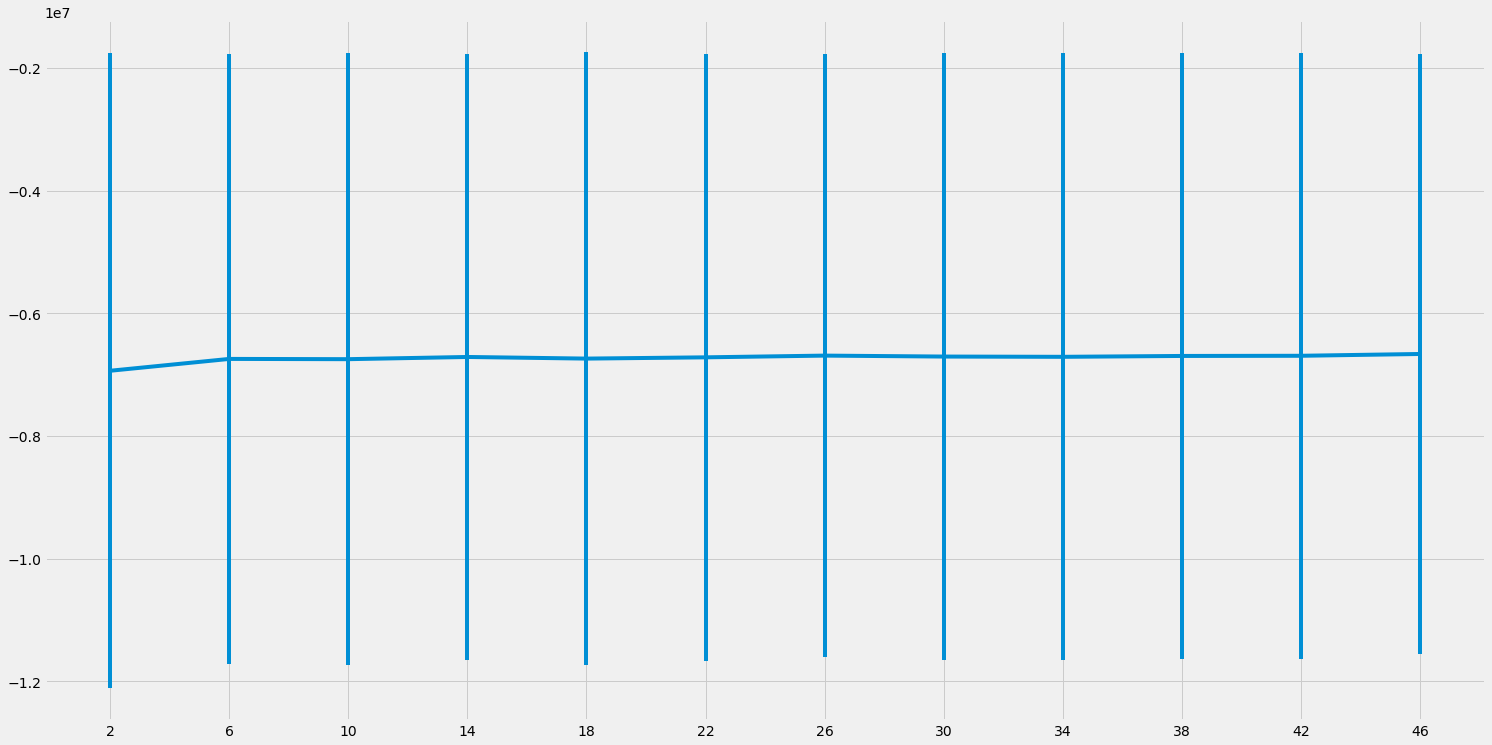

In [173]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=[23,12])
k_grid_results = pd.DataFrame(k_grid_cv.cv_results_)
plt.errorbar(np.arange(2,50,4), k_grid_results['mean_test_score'], yerr=k_grid_results['std_test_score'])
plt.grid(True)
# plt.yticks(np.arange(-6.9e6, -6.3e6, 0.05e6))
plt.xticks(np.arange(2,50,4));

In [175]:
kmax = 20
sil = []
iner = []
for k in range(2, kmax+1):
  kmeansmodel = KMeans(n_clusters = k).fit(wordDoc)
  labels = kmeansmodel.labels_
  inertia = kmeansmodel.inertia_
  sil.append(silhouette_score(wordDoc, labels, metric = 'euclidean'))
  iner.append(kmeansmodel.inertia_)

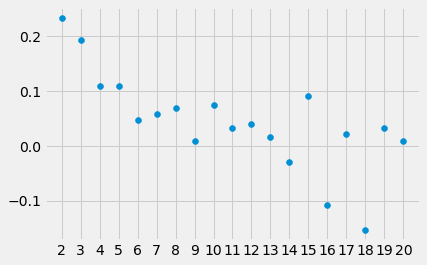

In [176]:
plt.scatter(np.arange(2,21), sil)
plt.grid(True)
plt.xticks(np.arange(2,21));

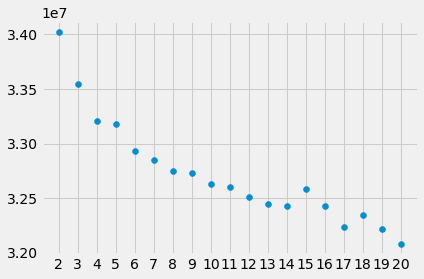

In [177]:
plt.scatter(np.arange(2,21), iner)
plt.grid(True)
plt.xticks(np.arange(2,21));

Observing the inertia and silhouette graphs, a k value of 8 appears to be a good option.

In [189]:
x_mean = pd.DataFrame(wordDoc).describe().loc['mean']

In [196]:
n_clusters = 8
selected_kmeans = KMeans(n_clusters=n_clusters).fit(wordDoc)
labels = selected_kmeans.labels_
cluster_centers = selected_kmeans.cluster_centers_
subtracted = cluster_centers - x_mean.to_numpy()

In [197]:
farthest = np.zeros([n_clusters,10])

for index, row in pd.DataFrame(subtracted).iterrows():
    descending_sorted = np.argsort(-row)
    farthest[index,:] = descending_sorted[0:10]

farthest_titles = np.empty([n_clusters,10], dtype='<U100')

for cluster in range(n_clusters):
    farthest_titles[cluster,:] = [title_list[i] for i in farthest[cluster,:].astype('int').tolist()]

pd.DataFrame(farthest_titles)

,0,1,2,3,4,5,6,7,8,9
0,"""Advances in the Physics of High-Temperature S...","""The Atom-Cavity Microscope: Single Atoms Boun...","""Quantum Criticality: Competing Ground States ...","""Negative Poisson's Ratios for Extreme States ...","""Self-Mode-Locking of Quantum Cascade Lasers w...","""Orbital Physics in Transition-Metal Oxides""","""Generating Solitons by Phase Engineering of a...","""Subatomic Features on the Silicon (111)-(7 x ...","""NEAR at Eros: Imaging and Spectral Results""","""Imaging Precessional Motion of the Magnetizat..."
1,"""Central Role for G Protein-Coupled Phosphoino...","""Noxa, a BH3-Only Member of the Bcl-2 Family a...","""Role of the Mouse ank Gene in Control of Tiss...","""Kinesin Superfamily Motor Protein KIF17 and m...","""Positional Syntenic Cloning and Functional Ch...","""Requirement of JNK for Stress-Induced Activat...","""Function of PI3Kg in Thymocyte Development, T...","""Regulation of STAT3 by Direct Binding to the ...","""Regulated Cleavage of a Contact-Mediated Axon...","""Requirement for RORg in Thymocyte Survival an..."
2,"""A Tale of Two Futures: HIV and Antiretroviral...","""Climate Extremes: Observations, Modeling, and...","""Lunar Impact History from <latex>$^{40}Ar/^{3...","""Correlates of Sleep and Waking in Drosophila ...","""Calcium Sensitivity of Glutamate Release in a...","""Change in the Probability for Earthquakes in ...","""Global Water Resources: Vulnerability from Cl...","""Upwelling Intensification as Part of the Plio...","""Role of Brain Insulin Receptor in Control of ...","""Response of Schwann Cells to Action Potential..."
3,"""Status and Improvements of Coupled General Ci...","""Sedimentary Rocks of Early Mars""","""Climate Extremes: Observations, Modeling, and...","""Rapid Changes in the Hydrologic Cycle of the ...","""A 22,000-Year Record of Monsoonal Precipitati...","""The Global Carbon Cycle: A Test of Our Knowle...","""Causes of Climate Change over the past 1000 Y...","""Climate Impact of Late Quaternary Equatorial ...","""Is El Nino Changing?""","""Internal Structure and Early Thermal Evolutio..."
4,"""A Mouse Chronology""","""Atom-Scale Research Gets Real""","""Meltdown on Long Island""","""Presidential Forum: Gore and Bush Offer Their...","""Help Needed to Rebuild Science in Yugoslavia""","""Silent No Longer: 'Model Minority' Mobilizes""","""I'd like to See America Used as a Global Lab""","""Soft Money's Hard Realities""","""Ecologists on a Mission to Save the World""","""Clones: A Hard Act to Follow"""
5,"""National Academy of Sciences Elects New Members""","""Corrections and Clarifications: Absorbing Phe...","""Corrections and Clarifications: Timing the An...","""Biological Control of Invading Species""","""Is Bigger Better in Cricket?""","""The Internet of Tomorrow""","""Corrections and Clarifications: Charon's Firs...","""Corrections and Clarifications: Unearthing Mo...","""Corrections and Clarifications: A Short Fe-Fe...","""Corrections and Clarifications: Biotech Resea..."
6,"""Three-Dimensional Structure of the Tn5 Synapt...","""Crystal Structure of the Ribonucleoprotein Co...","""The Complete Atomic Structure of the Large Ri...","""Positional Syntenic Cloning and Functional Ch...","""The Structural Basis of Ribosome Activity in ...","""Crystal Structure of gd T Cell Receptor Ligan...","""Signaling and Circuitry of Multiple MAPK Path...","""Architecture of RNA Polymerase II and Implica...","""Dual Signaling Regulated by Calcyon, a D1 Dop...","""Noxa, a BH3-Only Member of the Bcl-2 Family a..."
7,"""Replaying the Game: Hypnagogic Images in Norm...","""Glomalean Fungi from the Ordovician""","""An Empirical Assessment of Taxic Paleobiology""","""Graphite Polyhedral Crystals""","""The Prefrontal Cortex: Response Selection or ...","""Protein Interaction Mapping in C. elegans Usi...","""New Age Semiconductors Pick up the Pace""","""Identification of Vaccine Candidates against ...","""The Eye Injury of King Philip II and the Skel...","""Evidence for Genetic L

In [199]:
word_list.append('Cluster size limited')

n_words = len(selected_kmeans.labels_)
distances_to_center = np.zeros([n_words,2])

for word in range(n_words):
    cluster = selected_kmeans.labels_[word]
    cluster_center = cluster_centers[cluster]
    distances_to_center[word,0] = cluster
    distances_to_center[word,1] = distance.euclidean(cluster_center, wordDoc[word])

distances_to_center = pd.DataFrame(distances_to_center)

closest_words = np.empty([n_clusters,10])
closest_words[:] = np.NaN

for cluster in range(n_clusters):
    distances_per_cluster = distances_to_center.loc[distances_to_center[0] == cluster][1]
    closest = np.argsort(distances_per_cluster)[0:10].to_numpy()
    if len(closest) < 10:
        append = np.zeros([10 - len(closest),1])
        append[:] = len(title_list) - 1
        closest = np.append(closest, append)
    closest_words[cluster,:] = closest

In [200]:
closest_words_written = np.empty([n_clusters,10], dtype='<U100')

for cluster in range(n_clusters):
    closest_words_written[cluster,:] = [word_list[i] for i in closest_words[cluster,:].astype('int').tolist()]

pd.DataFrame(closest_words_written)


,0,1,2,3,4,5,6,7,8,9
0,distance,green,notes,transition,addressed,applied,biological,common,technology,called
1,vitro,particles,stars,dark,vector,complete,metal,spectrum,smaller,helix
2,fig,horizontal,horizontal,horizontal,horizontal,horizontal,horizontal,horizontal,horizontal,horizontal
3,numbers,host,isolated,appears,mol,examined,helix,structures,dark,synaptic
4,iron,taken,blood,drug,record,resistance,humans,promoter,method,tissue
5,practice,disulfide,microbes,opin,doses,worms,link,homology,averaging,spikes
6,see,brain,gfp,normal,study,two,age,scale,period,presence
7,fig,horizontal,horizontal,horizontal,horizontal,horizontal,horizontal,horizontal,horizontal,horizontal
